In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, datasets, regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_docs.plots
import tensorflow as tf
import numpy as np
import keras_tuner
import tensorboard
import tempfile
import pathlib
import os

2023-07-24 14:01:16.688632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/caiomarchiorato/Desktop/cotton_classification/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!pip install git+https://github.com/tensorflow/docs

## Configurações para melhorar a Pipeline de entrada

In [2]:
devices = tf.config.list_physical_devices()
print(devices)
a=tf.random.normal([100,100])
b=tf.random.normal([100,100])
c = a*b

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-24 14:01:22.043277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-24 14:01:22.043329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [4]:
tf.debugging.set_log_device_placement(False)
# Verifique as GPUs disponíveis
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))



GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LeNet5

In [37]:
from load_data.load_data import LoadData

train_data_dir = "to_torch/train/"
valid_data_dir = "to_torch/valid/"

train_data = LoadData(path= train_data_dir,
                      num_batches= 1,
                      image_size = 500)

valid_data = LoadData(path= valid_data_dir,
                      num_batches= 1,
                      image_size = 500)

train_data = train_data.get_data()
valid_data = valid_data.get_data()

for image_batch, labels_batch in train_data:
    print("Image_size:",image_batch.shape[2])
    break

Found 447 files belonging to 5 classes.


Found 25 files belonging to 5 classes.
Image_size: 500


2023-07-25 15:49:58.520311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]
2023-07-25 15:49:58.520824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]


In [43]:
#definindo a arquitetura da LeNet-5
model_lenet5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_batch.shape[2], image_batch.shape[2], 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')
])

# # Compilando o modelo
# model_lenet5.compile(optimizer='adam', 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])

# model_lenet5.summary()

In [41]:
from compile_and_fit.compile_and_fit import CompilerAndFit

compile_fit = CompilerAndFit(train_Data= train_data,
               valid_Data = valid_data,
               path = "lenet5_l2",
               monitor = "acc")

compileSGD_fit = CompilerAndFit(train_Data= train_data,
               valid_Data = valid_data,
               optmizer= "SGD",
               path = "lenet5_l2",
               monitor = "acc")

In [46]:
history = {}
history = compile_fit.compile_and_fit(model=model_lenet5,
                               max_epochs= 5)

Tamanho dos Batchs (1,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 249, 249, 6)       168       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 124, 124, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 14400)             0         
                                                                 
 dense_9 (Dense)             (

2023-07-25 16:05:39.367898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-25 16:05:39.447806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


447/447 [==============================] - ETA: 0s - loss: 14.5022 - acc: 0.4139 - top5-acc: 0.6174

2023-07-25 16:06:10.430780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch: 0, acc:0.4139,  loss:14.5022,  top5-acc:0.6174,  val_acc:0.2000,  val_loss:3.2766,  val_top5-acc:0.4000,  
447/447 [==============================] - 33s 70ms/step - loss: 14.5022 - acc: 0.4139 - top5-acc: 0.6174 - val_loss: 3.2766 - val_acc: 0.2000 - val_top5-acc: 0.4000
Epoch 2/5
447/447 [==============================] - 30s 68ms/step - loss: 2.8148 - acc: 0.3177 - top5-acc: 0.5570 - val_loss: 1.7132 - val_acc: 0.2800 - val_top5-acc: 0.6000
Epoch 3/5
447/447 [==============================] - 30s 67ms/step - loss: 4.6961 - acc: 0.3512 - top5-acc: 0.6107 - val_loss: 2.0496 - val_acc: 0.1200 - val_top5-acc: 0.4000
Epoch 4/5
447/447 [==============================] - 31s 68ms/step - loss: 7.7264 - acc: 0.4251 - top5-acc: 0.6510 - val_loss: 3.1883 - val_acc: 0.2400 - val_top5-acc: 0.4400
Epoch 5/5
447/447 [==============================] - 30s 67ms/step - loss: 3.6961 - acc: 0.5615 - top5-acc: 0.7651 - val_loss: 4.4475 - val_acc: 0.1600 - val_top5-acc: 0.3200


TypeError: 'History' object is not subscriptable

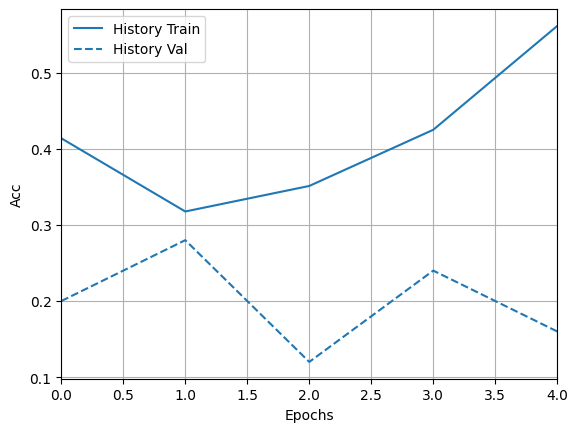

In [50]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
history_dict = {'history': history}
plotter.plot(history_dict)

#linha de accuracy (corrigir - deu erro)
val_acc = history["lenet5"].history['val_acc']
max_val_acc = max(val_acc)
print("Maior valor de val_acc observado:", max_val_acc)
plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

### LeNet5 - regularizers L2

In [ ]:
model_lenet5_l2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.25),
    
    tf.keras.layers.Dense(84, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.25),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
history2 = {}
history2["lenet5_l2"] = compile_and_fit(model_lenet5_l2,
                                           train_Data= train_data,
                                           validation_Data= valid_data,
                                           max_epochs= 50,
                                           callback_path= "lenet5_l2")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot(history2)

val_acc = history2["lenet5_l2"].history['val_acc']
max_val_acc = max(val_acc)

print("Maior valor de val_acc observado:", max_val_acc)

plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

### LeNet5 - compiler SGD 

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps= steps_per_epoch*100,
    decay_rate=1,
    staircase=False
)

def get_log_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Pasta criada com sucesso")
    else:
        print("A pasta já existe")
    return path


def get_callbacks(path):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='acc', patience=20, mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir= get_log_dir(path)),
    ]

def get_optimizer():
    return tf.keras.optimizers.SGD(lr_schedule)

def compile_and_fit(model, train_Data, validation_Data, max_epochs, callback_path,optimizer= None):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer= optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics= [
                             keras.metrics.SparseCategoricalAccuracy(name="acc"),
                             keras.metrics.SparseTopKCategoricalAccuracy(2, name="top5-acc")]
                         )
    model.summary()
    
    history = model.fit(
        train_Data,
        steps_per_epoch= steps_per_epoch,
        validation_data= validation_Data,
        epochs= max_epochs,
        callbacks= get_callbacks(callback_path)
    )
    return history

model_lenet5_l2_sgd = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(84, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
history3 = {}
history3["lenet5_sgd"] = compile_and_fit(model_lenet5_l2_sgd,
                                           train_Data= train_data,
                                           validation_Data= valid_data,
                                           max_epochs= 100,
                                           callback_path= "logs_lenet5")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot(history3)

val_acc = history3["lenet5_sgd"].history['val_acc']
max_val_acc = max(val_acc)

print("Maior valor de val_acc observado:", max_val_acc)

plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

In [ ]:
predict = model.predict_generator(test_generator)

get_best_hp(tuner_bayesian_optimization)

In [ ]:
import matplotlib.pyplot as plt

output_image = model_lenet5_l2.predict(test_data)
plt.imshow(output_image)
plt.show

### LeNet5 - Dropouts 0.25

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps= steps_per_epoch*100,
    decay_rate=1,
    staircase=False
)

def get_log_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Pasta criada com sucesso")
    else:
        print("A pasta já existe")
    return path


def get_callbacks(path):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='acc', patience=20, mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir= get_log_dir(path)),
    ]

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, train_Data, validation_Data, max_epochs, callback_path,optimizer= None):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer= optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics= [
                             keras.metrics.SparseCategoricalAccuracy(name="acc"),
                             keras.metrics.SparseTopKCategoricalAccuracy(2, name="top5-acc")]
                         )
    model.summary()
    
    history = model.fit(
        train_Data,
        steps_per_epoch= steps_per_epoch,
        validation_data= validation_Data,
        epochs= max_epochs,
        callbacks= get_callbacks(callback_path)
    )
    return history

In [ ]:

# Definindo a arquitetura da LeNet-5
model_lenet5_drop025 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
history4 = {}
history4["lenet5_drop025"] = compile_and_fit(model_lenet5_drop025,
                                           train_Data= train_data,
                                           validation_Data= valid_data,
                                           max_epochs= 100,
                                           callback_path= "logs_lenet5")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot(history4)

val_acc = history4["lenet5_drop025"].history['val_acc']
max_val_acc = max(val_acc)

print("Maior valor de val_acc observado:", max_val_acc)

plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

### LeNet5 - Dropout 0.5 + L2

In [ ]:
model_lenet5_dropout_l2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(84, activation='relu',
                          kernel_regularizer= regularizers.l2(0.01)),
    tf.keras.layers.Dropout(rate=0.5),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')])

In [ ]:
history5 = {}
history5["lenet5_drop_l2"] = compile_and_fit(model_lenet5_dropout_l2,
                                           train_Data= train_data,
                                           validation_Data= valid_data,
                                           max_epochs= 100,
                                           callback_path= "logs_lenet5_dropout_l2")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot(history5)

val_acc = history5["lenet5_drop_l2"].history['val_acc']
max_val_acc = max(val_acc)

print("Maior valor de val_acc observado:", max_val_acc)

plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

### LeNet5 - (-MaxPooling)

In [ ]:
model_lenet5_maxpooling = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size, image_size))
    tf.keras.layers.Conv2D(6, (3, 3), activation='relu',strides= (2,2), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    #TESTAR FUNÇAO SIGMOID (0)
    tf.keras.layers.Dense(5, activation='softmax')])

In [ ]:
history6 = {}
history6["lenet5_drop_maxp"] = compile_and_fit(model_lenet5_maxpooling,
                                           train_Data= train_data,
                                           validation_Data= valid_data,
                                           max_epochs= 100,
                                           callback_path= "logs_lenet5_dropout_l2")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc')
plotter.plot(history6)

val_acc = history6["lenet5_drop_maxp"].history['val_acc']
max_val_acc = max(val_acc)

print("Maior valor de val_acc observado:", max_val_acc)

plt.axhline(max_val_acc, color='red', linestyle='dashed', label='Max val_acc')
plt.legend()

# Mostrar o gráfico
plt.show()

## TensorBoard

In [ ]:
import tensorboard
%tensorboard --logdir ./logs
